In [1]:
!pip install evaluate


In [2]:
!pip install --upgrade datasets fsspec


  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [3]:
import datasets
print(datasets.__version__)


3.6.0


In [4]:
!pip install --upgrade huggingface_hub


Labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Epoch 1/5 | Train Loss: 0.6794 | Train Acc: 75.09% | Val Loss: 0.2782 | Val Acc: 91.80%
✅ Best model saved!
Epoch 2/5 | Train Loss: 0.2333 | Train Acc: 92.73% | Val Loss: 0.2340 | Val Acc: 93.20%
✅ Best model saved!
Epoch 3/5 | Train Loss: 0.1810 | Train Acc: 93.92% | Val Loss: 0.2381 | Val Acc: 93.60%
✅ Best model saved!
Epoch 4/5 | Train Loss: 0.1610 | Train Acc: 94.80% | Val Loss: 0.2516 | Val Acc: 93.25%
Epoch 5/5 | Train Loss: 0.1381 | Train Acc: 95.51% | Val Loss: 0.2946 | Val Acc: 94.00%
✅ Best model saved!

Train Classification Report:
              precision    recall  f1-score   support

     sadness      0.988     0.986     0.987      4666
         joy      0.997     0.945     0.970      5362
        love      0.821     0.998     0.901      1304
       anger      0.978     0.975     0.976      2159
        fear      0.935     0.969     0.952      1937
    surprise      0.957     0.860     0.906       572

    accuracy                          0.965     16000
   macro avg    

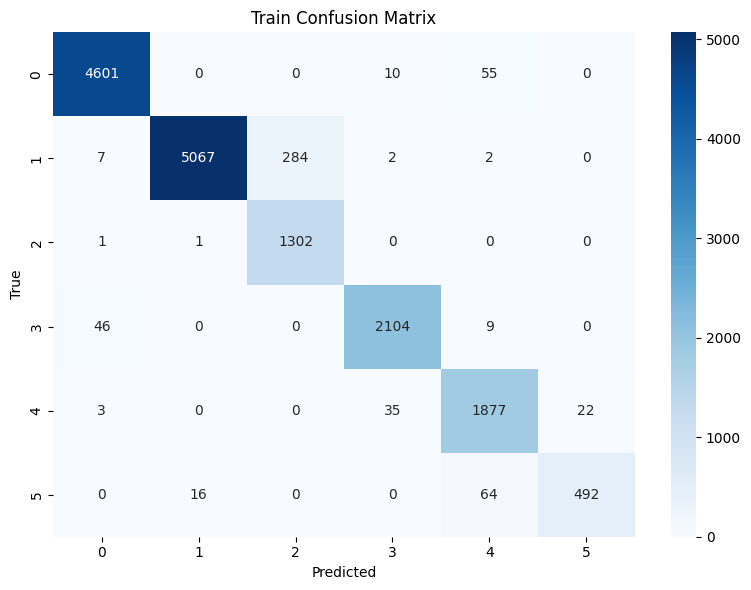


Validation Classification Report:
              precision    recall  f1-score   support

     sadness      0.960     0.964     0.962       550
         joy      0.981     0.935     0.957       704
        love      0.808     0.972     0.883       178
       anger      0.955     0.931     0.943       275
        fear      0.877     0.939     0.907       212
    surprise      0.941     0.790     0.859        81

    accuracy                          0.940      2000
   macro avg      0.920     0.922     0.918      2000
weighted avg      0.944     0.940     0.941      2000



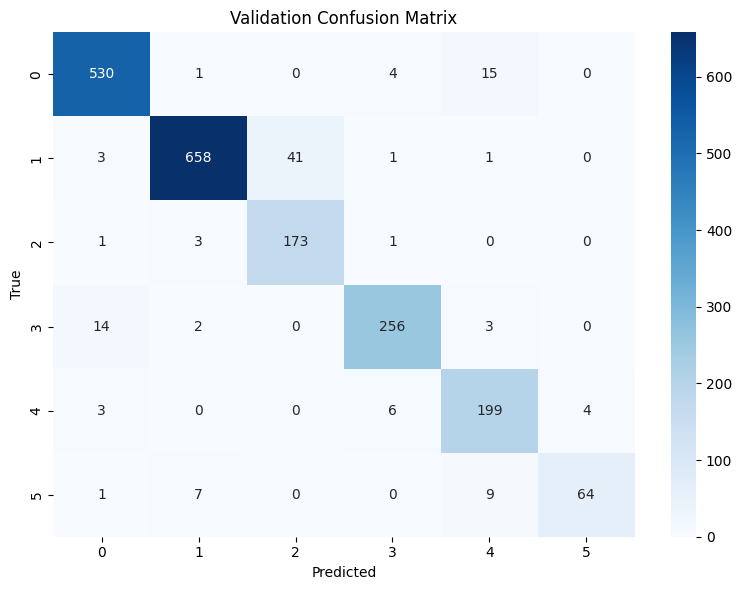


Test Classification Report:
              precision    recall  f1-score   support

     sadness      0.959     0.976     0.968       581
         joy      0.980     0.922     0.950       695
        love      0.762     0.969     0.853       159
       anger      0.955     0.927     0.941       275
        fear      0.878     0.902     0.890       224
    surprise      0.750     0.636     0.689        66

    accuracy                          0.930      2000
   macro avg      0.881     0.889     0.882      2000
weighted avg      0.934     0.930     0.931      2000



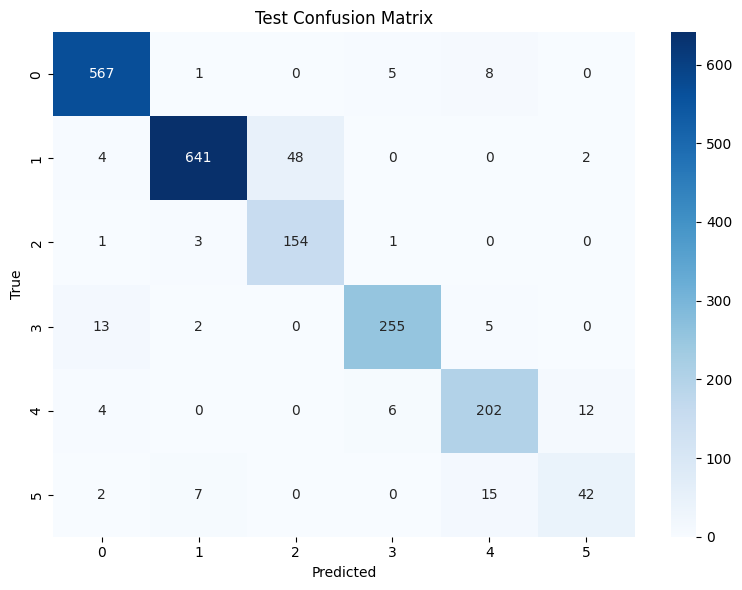

In [9]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Load Dataset and Tokenize
# -------------------------
dataset = load_dataset("dair-ai/emotion")

labels = dataset["train"].features["label"].names
num_labels = len(labels)
print(f"Labels: {labels}")

model_name = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

encoded_dataset = dataset.map(tokenize, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# -------------------------
# 2. Dataset class and DataLoaders
# -------------------------
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return {
            "input_ids": self.dataset[idx]["input_ids"],
            "attention_mask": self.dataset[idx]["attention_mask"],
            "labels": self.dataset[idx]["labels"]
        }

train_ds = EmotionDataset(encoded_dataset["train"])
val_ds = EmotionDataset(encoded_dataset["validation"])
test_ds = EmotionDataset(encoded_dataset["test"])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# -------------------------
# 3. Model Definition with Weighted Loss
# -------------------------
class DebertaClassifier(nn.Module):
    def __init__(self, model_name, num_labels, class_weights):
        super().__init__()
        config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
        self.backbone = AutoModel.from_pretrained(model_name, config=config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        # Use the [CLS] token representation (first token)
        pooled = outputs.last_hidden_state[:, 0]
        dropped = self.dropout(pooled)
        logits = self.classifier(dropped)
        loss = self.loss_fn(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

# -------------------------
# 4. Setup device, class weights, model, optimizer
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_train = encoded_dataset["train"]["labels"].numpy()
class_weights_np = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)

model = DebertaClassifier(model_name, num_labels, class_weights).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# -------------------------
# 5. Training loop with Early Stopping
# -------------------------
EPOCHS = 5
best_val_acc = 0
patience = 2
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, labels)
        loss = outputs["loss"]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs["logits"].argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, labels)
            loss = outputs["loss"]
            val_loss += loss.item()
            val_preds.extend(outputs["logits"].argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    avg_val_loss = val_loss / len(val_loader)

    print(
        f"Epoch {epoch + 1}/{EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
        f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%"
    )

    # Early stopping & save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_deberta_model.pth")
        print("✅ Best model saved!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

# -------------------------
# 6. Evaluation function
# -------------------------
label_names = dataset["train"].features["label"].names  # Make sure this is defined globally

def evaluate_model(name, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs["logits"], dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n{name} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names, digits=3))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# -------------------------
# 7. Load best model and evaluate
# -------------------------
model.load_state_dict(torch.load("best_deberta_model.pth"))
evaluate_model("Train", train_loader)
evaluate_model("Validation", val_loader)
evaluate_model("Test", test_loader)


In [10]:
from sklearn.metrics import accuracy_score

model.load_state_dict(torch.load("best_deberta_model.pth"))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs["logits"], dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")



✅ Test Accuracy: 93.05%
